# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra, Mihir Suvarna, Daniel Sialm

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Due to the increasing importance of the task of text recognition, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Dataset

In [2]:
letter_to_label = dict()
classes_collected = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes_collected)):
    letter_to_label[classes_collected[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [4]:
import os
import shutil
import glob

from PIL import Image
import torchvision.transforms as transforms

src_dir = 'dataset'
transform = transforms.ToTensor()

files_train = []
files_val = []
files_test = []
for i in range(0,16): files_train.append('P' + str(i))
for i in range(16,21): files_val.append('P' + str(i))
for i in range(21,24): files_test.append('P' + str(i))

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    file = ftitle.split("_")[0].split("-")[0]
    im = Image.open(f).convert('L')

    if file in files_train:
        imgs_train.append(transform(im).detach().numpy())
        labels_train.append(letter_to_label[letter])
    elif file in files_val:
        imgs_val.append(transform(im).detach().numpy())
        labels_val.append(letter_to_label[letter])
    elif file in files_test:
        imgs_test.append(transform(im).detach().numpy())
        labels_test.append(letter_to_label[letter])
    
data_train = torch.tensor(imgs_train)
data_val = torch.tensor(imgs_val)
data_test = torch.tensor(imgs_test)
labels_train = torch.tensor(np.array(labels_train))
labels_val = torch.tensor(np.array(labels_val))
labels_test = torch.tensor(np.array(labels_test))

print(data_train.shape, data_val.shape, data_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

torch.Size([4160, 1, 28, 28]) torch.Size([1300, 1, 28, 28]) torch.Size([780, 1, 28, 28])
torch.Size([4160]) torch.Size([1300]) torch.Size([780])


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: m


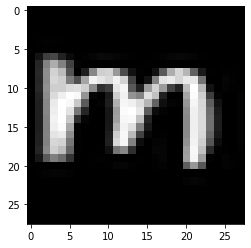

In [5]:
# Data visualization

# print classes
print(classes_collected)
# print label
index = 125
plt.imshow(data_train[index].reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes_collected[labels_train[index].item()])

In [18]:
batch_size = 64

train_set_collected = torch.utils.data.TensorDataset(data_train, labels_train)
val_set_collected = torch.utils.data.TensorDataset(data_val, labels_val)
test_set_collected = torch.utils.data.TensorDataset(data_test, labels_test)

train_loader_collected = torch.utils.data.DataLoader(train_set_collected, batch_size=batch_size, shuffle=True)
val_loader_collected = torch.utils.data.DataLoader(val_set_collected, batch_size=batch_size, shuffle=True)
test_loader_collected = torch.utils.data.DataLoader(test_set_collected, batch_size=batch_size, shuffle=True)

## Defining a basic LetterCNN

In [13]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [19]:
# Testing the model above, TODO remove before submission
model_test = letterCNN(classes_collected)
for inputs, labels in train_loader_collected:
    print(inputs.shape)
    print(labels.shape)
    print(inputs.dtype, labels.dtype)
    outputs = model_test.forward(inputs)
    print(outputs.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.float32 torch.int64
torch.Size([64, 27])


## Testing the basic LetterCNN

In [15]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                labels = labels.type(torch.long)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    labels = labels.type(torch.long)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

def display_contingency_matrix(num_classes, pred, true):
    contingency = np.zeros((num_classes, num_classes))
    for i in range(len(pred)):
        contingency[int(pred[i])][int(true[i])] += 1

    plt.matshow(contingency)
    plt.xlabel("true")
    plt.ylabel("predictions")
    plt.colorbar()

In [20]:
model1 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
train_network(model1, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 2.38170
   Val loss: 2.23527

EPOCH 1
 Train loss: 0.98055
   Val loss: 2.07808

EPOCH 2
 Train loss: 0.55748
   Val loss: 2.28177

EPOCH 3
 Train loss: 0.33444
   Val loss: 2.48323

EPOCH 4
 Train loss: 0.20414
   Val loss: 2.55638

EPOCH 5
 Train loss: 0.13417
   Val loss: 2.78627

EPOCH 6
 Train loss: 0.08852
   Val loss: 3.02216

EPOCH 7
 Train loss: 0.06229
   Val loss: 3.07117

EPOCH 8
 Train loss: 0.04615
   Val loss: 3.15746

EPOCH 9
 Train loss: 0.03387
   Val loss: 3.35683



Test accuracy: 48.718


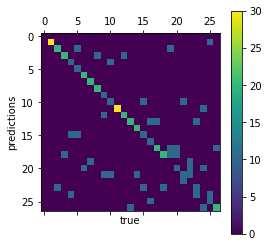

In [21]:
acc, true, pred = test_network(model1, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

We can see that there is quite a bit of overfitting going on. Also, our accuracy is quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained which. This ends up heavily overrepresenting our training dataset towards the handwriting of a few people. Consequently, our model does not generalize well. We can also see this from the increasing validation loss. 

Thus, we will combine our dataset with the EMNIST dataset to create a better model.

### EMNIST Data Set

In [22]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [23]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.78*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [24]:
# initialize the data sets
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: w


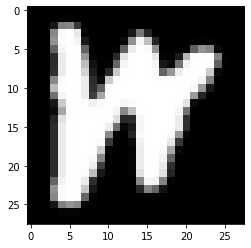

In [25]:
# Visualizing EMNIST

# print classes
print(train_set.classes)
classes = train_set.classes
# print label
index = 0
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

### Combining EMNIST with our Data

In [26]:
combined_batch_size=64

combined_train = []
combined_train_labels = []
combined_val = []
combined_val_labels = []
combined_test = []
combined_test_labels = []

for inputs, labels in train_loader:
    combined_train.append( inputs[0].detach().numpy() )
    combined_train_labels.append( labels[0].item() )
for inputs, labels in train_loader_collected:
    combined_train.append( inputs[0].detach().numpy() )
    combined_train_labels.append( labels[0].item() )
for inputs, labels in val_loader:
    combined_val.append( inputs[0].detach().numpy() )
    combined_val_labels.append( labels[0].item() )
for inputs, labels in val_loader_collected:
    combined_val.append( inputs[0].detach().numpy() )
    combined_val_labels.append( labels[0].item() )
for inputs, labels in test_loader:
    combined_test.append( inputs[0].detach().numpy() )
    combined_test_labels.append( labels[0].item() )
for inputs, labels in test_loader_collected:
    combined_test.append( inputs[0].detach().numpy() )
    combined_test_labels.append( labels[0].item() )

combined_train = np.array(combined_train)
combined_train_labels = np.array(combined_train_labels)
combined_val = np.array(combined_val)
combined_val_labels = np.array(combined_val_labels)
combined_test = np.array(combined_test)
combined_test_labels = np.array(combined_test_labels)

print(combined_train.shape)
print(combined_train_labels.shape)
print(combined_val.shape)
print(combined_val_labels.shape)
print(combined_test.shape)
print(combined_test_labels.shape)

combined_train = torch.Tensor(combined_train)
combined_train_labels = torch.Tensor(combined_train_labels)

combined_val = torch.Tensor(combined_val)
combined_val_labels = torch.Tensor(combined_val_labels)

combined_test = torch.Tensor(combined_test)
combined_test_labels = torch.Tensor(combined_test_labels)


cobined_train_set = torch.utils.data.TensorDataset(combined_train, combined_train_labels)
combined_train_loader = torch.utils.data.DataLoader(cobined_train_set, batch_size=combined_batch_size, shuffle=True)

cobined_val_set = torch.utils.data.TensorDataset(combined_val, combined_val_labels)
combined_val_loader = torch.utils.data.DataLoader(cobined_val_set, batch_size=combined_batch_size, shuffle=True)

cobined_test_set = torch.utils.data.TensorDataset(combined_test, combined_test_labels)
combined_test_loader = torch.utils.data.DataLoader(cobined_test_set, batch_size=combined_batch_size, shuffle=True)

print(len(combined_train_loader))
print(len(combined_val_loader))
print(len(combined_test_loader))

(46865, 1, 28, 28)
(46865,)
(13221, 1, 28, 28)
(13221,)
(20813, 1, 28, 28)
(20813,)
733
207
326


## Making a new LetterCNN on the Combined Dataset

In [ ]:
model2 = letterCNN(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_network(model2, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.05750
   Val loss: 0.69648

EPOCH 1
 Train loss: 0.59354
   Val loss: 0.53468

EPOCH 2
 Train loss: 0.47107
   Val loss: 0.46598

EPOCH 3
 Train loss: 0.41417
   Val loss: 0.44272

EPOCH 4
 Train loss: 0.37996
   Val loss: 0.43202

EPOCH 5
 Train loss: 0.35378
   Val loss: 0.42302

EPOCH 6
 Train loss: 0.33716
   Val loss: 0.41393

EPOCH 7


Test accuracy: 85.236


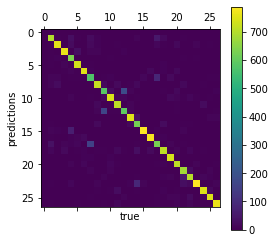

In [272]:
acc, true, pred = test_network(model1, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1.classes), pred, true)

#### Test model on collected data

In [277]:
model2 = modelCM(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
train_network(model2, test_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 1
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 2
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 3
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 4
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 5
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 6
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 7
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 8
 Train loss: 3.29600
   Val loss: 3.30651

EPOCH 9
 Train loss: 3.29600
   Val loss: 3.30651



Test accuracy: 42.147


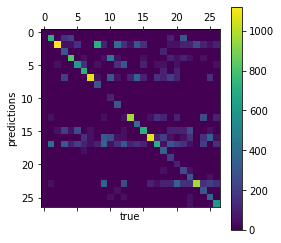

In [278]:
acc, true, pred = test_network(model1, data_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(classes_collected), pred, true)

### Smaller Kernel Size

In [17]:
class modelCMS(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1352, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [18]:
model1s = modelCMS(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1s.parameters(), lr=.001)
train_network(model1s, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.23041
   Val loss: 0.97628

EPOCH 1
 Train loss: 0.87156
   Val loss: 0.82428

EPOCH 2
 Train loss: 0.71721
   Val loss: 0.68793

EPOCH 3
 Train loss: 0.61153
   Val loss: 0.61068

EPOCH 4
 Train loss: 0.54508
   Val loss: 0.57422

EPOCH 5
 Train loss: 0.50417
   Val loss: 0.53292

EPOCH 6
 Train loss: 0.47292
   Val loss: 0.50506

EPOCH 7
 Train loss: 0.44726
   Val loss: 0.50167

EPOCH 8
 Train loss: 0.42715
   Val loss: 0.48336

EPOCH 9
 Train loss: 0.40840
   Val loss: 0.46216



Test accuracy: 85.981


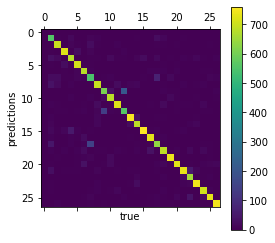

In [19]:
acc, true, pred = test_network(model1s, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model1s.classes), pred, true)

### Double Convolution Layer with MaxPool

In [96]:
class modelCMCM(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [102]:
model2 = modelCMCM(classes_collected)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=.0001)
train_network(model2, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=100)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.23556
   Val loss: 3.22127

EPOCH 1
 Train loss: 3.13745
   Val loss: 3.11314

EPOCH 2
 Train loss: 2.89606
   Val loss: 2.86248

EPOCH 3
 Train loss: 2.44638
   Val loss: 2.53783

EPOCH 4
 Train loss: 1.95489
   Val loss: 2.29939

EPOCH 5
 Train loss: 1.59228
   Val loss: 2.14010

EPOCH 6
 Train loss: 1.34678
   Val loss: 2.03265

EPOCH 7
 Train loss: 1.17209
   Val loss: 1.96447

EPOCH 8
 Train loss: 1.03979
   Val loss: 1.92507

EPOCH 9
 Train loss: 0.93456
   Val loss: 1.90356

EPOCH 10
 Train loss: 0.84709
   Val loss: 1.89181

EPOCH 11
 Train loss: 0.77176
   Val loss: 1.88649

EPOCH 12
 Train loss: 0.70542
   Val loss: 1.88480

EPOCH 13
 Train loss: 0.64604
   Val loss: 1.88578

EPOCH 14
 Train loss: 0.59226
   Val loss: 1.88895

EPOCH 15
 Train loss: 0.54318
   Val loss: 1.89391

EPOCH 16
 Train loss: 0.49794
   Val loss: 1.90015

EPOCH 17
 Train loss: 0.45613
   Val loss: 1.90849

EPOCH 18
 Train loss: 0.41732
   Val loss: 1.91881

EPOCH 19
 Train loss: 

Test accuracy: 57.692


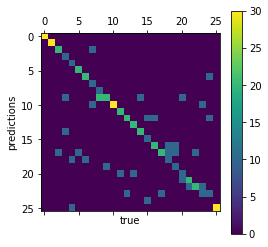

In [103]:
acc, true, pred = test_network(model2, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model2.classes), pred, true)

### Single Convolution Network with Average Pool

In [104]:
class modelCA(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            

    def forward(self, x):
        return self.layers(x)

In [105]:
model3 = modelCA(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=.001)
train_network(model3, train_loader, val_loader, criterion, optimizer, nepoch=10)

NameError: name 'classes' is not defined

Test accuracy: 87.284


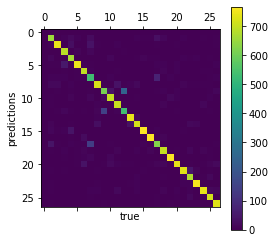

In [25]:
acc, true, pred = test_network(model3, test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model3.classes), pred, true)

## Visualizing Optimized Inputs

In [26]:
class OptimizeInput(nn.Module):
    def __init__(self, learned_model, input_shape=(1, 1, 28, 28)):
        super().__init__()
        self.learned_model = learned_model
        self.optimized_input = torch.zeros(input_shape, requires_grad=True)
        
    def forward(self):
        return self.learned_model(self.optimized_input)
    
    def parameters(self):
        return [self.optimized_input]

In [27]:
# Given model, get optimized input for each character
def get_optimized_inputs(model, nepochs = 10000):
    targets = torch.arange(len(model.classes)).long()
    optimized_inputs = {}

    for t in targets:
        # train input
        input_model = OptimizeInput(model)
        optimizer = torch.optim.Adam(input_model.parameters(), lr=.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(nepochs):
            optimizer.zero_grad()
            outputs = input_model()
            loss = criterion(outputs, t.reshape(1))
            loss.backward()
            optimizer.step()
        print("finished %s with %0.5f loss" % (model.classes[t], loss.item()), end = "\t")
        optimized_inputs[model.classes[t]] = input_model.optimized_input.detach().numpy().reshape((28, 28))
        
        # test input
        tensor = torch.Tensor(optimized_inputs[model.classes[t]].reshape(1, 1, 28, 28))
        with torch.no_grad():
            output = model(tensor)
        prob = output.squeeze().detach().numpy()
        pred = model.classes[torch.argmax(output, dim=1)]
        print(f"Expected: {model.classes[t]}. Predicted: {pred}.")
    return optimized_inputs

In [28]:
optimized_inputs = get_optimized_inputs(model2, nepochs=1000)

finished N/A with 0.64832 loss	Expected: N/A. Predicted: N/A.
finished a with 0.00029 loss	Expected: a. Predicted: a.
finished b with 0.00020 loss	Expected: b. Predicted: b.
finished c with 0.00013 loss	Expected: c. Predicted: c.
finished d with 0.00031 loss	Expected: d. Predicted: d.
finished e with 0.00019 loss	Expected: e. Predicted: e.
finished f with 0.00012 loss	Expected: f. Predicted: f.
finished g with 0.00011 loss	Expected: g. Predicted: g.
finished h with 0.00022 loss	Expected: h. Predicted: h.
finished i with 0.00004 loss	Expected: i. Predicted: i.
finished j with 0.00006 loss	Expected: j. Predicted: j.
finished k with 0.00013 loss	Expected: k. Predicted: k.
finished l with 0.00003 loss	Expected: l. Predicted: l.
finished m with 0.00016 loss	Expected: m. Predicted: m.
finished n with 0.00016 loss	Expected: n. Predicted: n.
finished o with 0.00062 loss	Expected: o. Predicted: o.
finished p with 0.00009 loss	Expected: p. Predicted: p.
finished q with 0.00011 loss	Expected: q. 

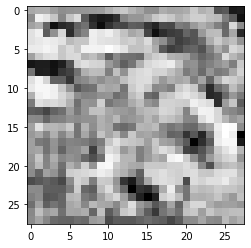

In [29]:
letter = 'b'
letter_visualized = optimized_inputs[letter].T
plt.imshow(letter_visualized, cmap='Greys_r')